In [1]:
!pip install imbalanced-learn shap --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             precision_recall_curve, average_precision_score,
                             f1_score, matthews_corrcoef, cohen_kappa_score)
from imblearn.over_sampling import SMOTE
import shap

In [4]:
import joblib
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Load dataset
df = pd.read_csv('/content/creditcard.csv')
print("Dataset shape:", df.shape)
print("Fraudulent transactions:", df['Class'].sum())

Dataset shape: (284807, 31)
Fraudulent transactions: 492


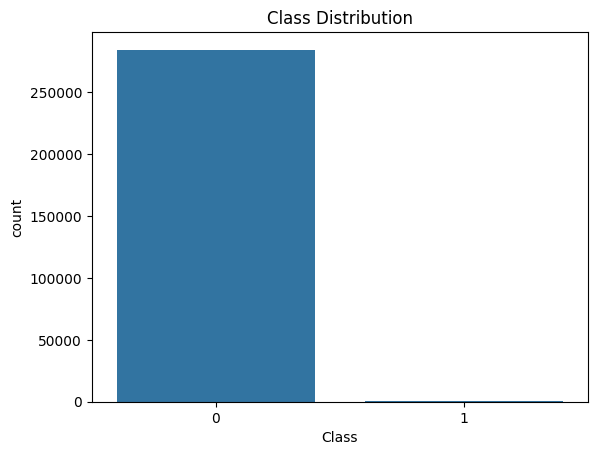

In [7]:
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()


In [8]:
# Feature Engineering
df['log_amount'] = np.log1p(df['Amount'])
df.drop(['Amount'], axis=1, inplace=True)

In [9]:
# Split features and labels
X = df.drop('Class', axis=1)
y = df['Class']

In [10]:
# Train, validation, test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)  # 60% train, 20%

In [11]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [12]:
# Preprocessing pipeline
num_features = ['Time', 'log_amount']
scaler = StandardScaler()
preprocessor = ColumnTransformer(transformers=[('num', scaler, num_features)], remainder='passthrough')

In [14]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

In [22]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt']
}

# Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [23]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

In [24]:
search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=5, cv=cv,
                            scoring='f1', verbose=1, n_jobs=-1)

In [25]:
search.fit(X_train_res, y_train_res)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Time',
                                                                                'log_amount'])])),
                                             ('classifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [None, 10],
                                        'classifier__max_features': ['sqrt'],
                                        'classifier__min_samples_leaf': [1, 2],
                                        'classifier__n_estimators': [50, 100]},
                   scoring='f1', verbose=1)

In [26]:
clf = search.best_estimator_
print("Best Parameters:", search.best_params_)

Best Parameters: {'classifier__n_estimators': 100, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': None}


In [27]:
joblib.dump(clf, 'rf_fraud_model_optimized.pkl')

['rf_fraud_model_optimized.pkl']

In [28]:
y_val_pred = clf.predict(X_val)
y_val_proba = clf.predict_proba(X_val)[:, 1]

In [29]:
print("\nValidation Set Metrics")
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))
print("ROC AUC:", roc_auc_score(y_val, y_val_proba))
print("PR AUC:", average_precision_score(y_val, y_val_proba))
print("Matthews Corrcoef:", matthews_corrcoef(y_val, y_val_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_val, y_val_pred))


Validation Set Metrics
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.88      0.78      0.82        99

    accuracy                           1.00     56962
   macro avg       0.94      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962

F1 Score: 0.8235294117647058
ROC AUC: 0.9534047543297846
PR AUC: 0.7953096285084822
Matthews Corrcoef: 0.824672967855489
Cohen's Kappa: 0.8232402743155042


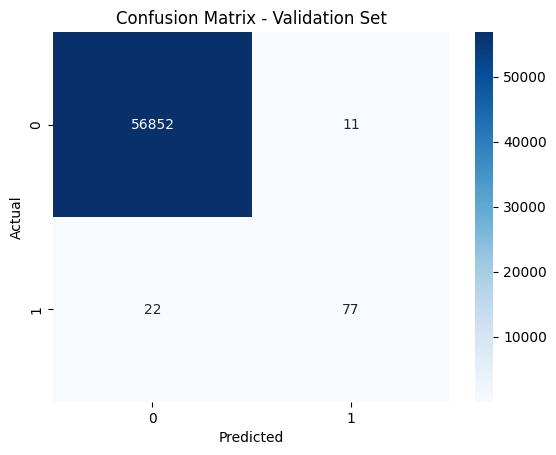

In [30]:
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [31]:
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]

In [32]:
print("\nTest Set Metrics")
print("F1 Score:", f1_score(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_test_proba))
print("PR AUC:", average_precision_score(y_test, y_test_proba))


Test Set Metrics
F1 Score: 0.8367346938775511
ROC AUC: 0.9599645376580569
PR AUC: 0.861337032825205


In [37]:
print("\nRunning SHAP explainability on sample...")


Running SHAP explainability on sample...


In [38]:
fitted_preprocessor = clf.named_steps['preprocessing']

In [39]:
X_val_transformed = fitted_preprocessor.transform(X_val)

In [40]:
sample_idx = np.random.choice(X_val.shape[0], size=500, replace=False)
X_sample = X_val_transformed[sample_idx]

In [41]:
explainer = shap.TreeExplainer(clf.named_steps['classifier'])
shap_values = explainer.shap_values(X_sample)

<Figure size 640x480 with 0 Axes>

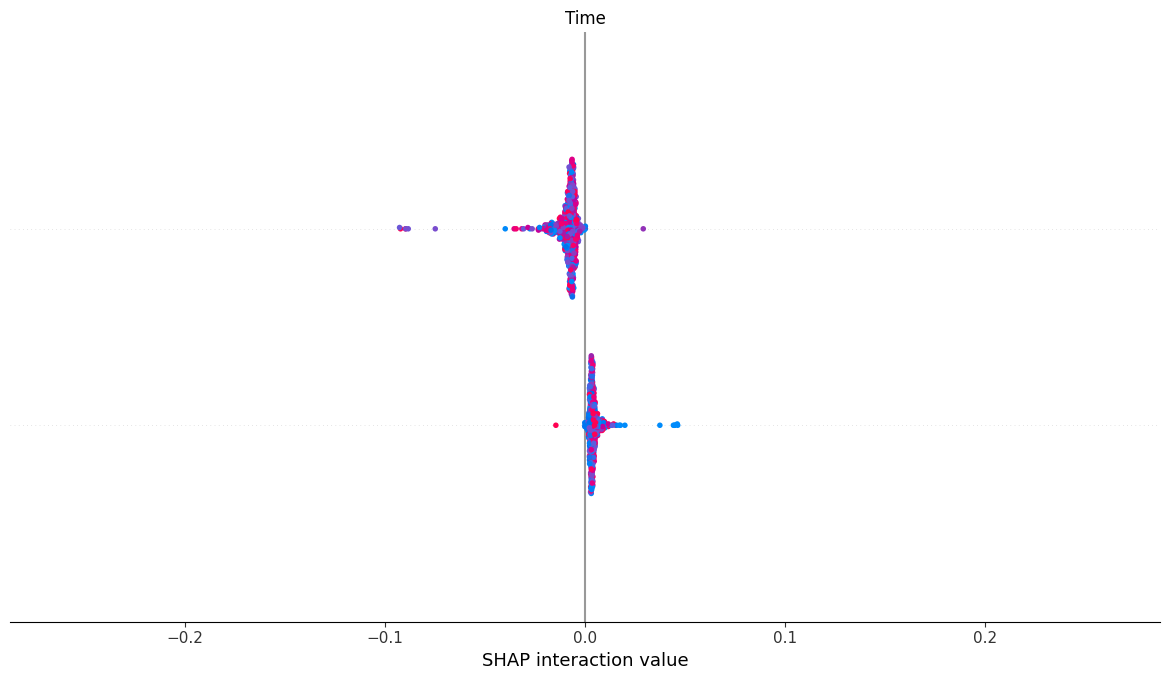

In [45]:
shap.summary_plot(shap_values, X_sample, feature_names=X_val.columns.tolist())